# LA RESERVOIRS CLASSIFIER

## Import Dependencies

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report
from sklearn.cross_validation import cross_val_score

% matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/Users/eastblue/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
print("Python Version:", sys.version)
%reload_ext version_information
%version_information numpy, scipy, pandas, matplotlib, seaborn, sklearn

Python Version: 3.6.1 |Anaconda custom (x86_64)| (default, Mar 22 2017, 19:25:17) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


Software versions
Python 3.6.1 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 5.1.0
OS Darwin 16.5.0 x86_64 i386 64bit
numpy 1.12.1
scipy 0.19.0
pandas 0.19.2
matplotlib 2.0.0
seaborn 0.7.1
sklearn 0.18.1
Tue May 16 19:54:52 2017 PDT

# SHAPE DATA:
## Build dataframe for storage_af values

In [3]:
file_path = 'StorageAF_res_columns_final.csv'
# file_path = 'StorageAF_rotated.csv'
raw_df = pd.read_csv(file_path)
raw_df.head()

,DATE,BRV,CAS,CGS,DMV,MHW,PRR,PRU,PYM,RLC,SGB,SGC,SKN,SLW,SVO
0,6/1/00,0.80419,0.95060,0.44565,0.26514,0.79516,0.85646,0.735,0.87709,0.90958,0.62753,0.3370,0.86686,0.97986,0.02023
1,7/1/00,0.77514,0.92983,0.37853,0.28669,0.71482,0.84980,0.739,0.91191,0.84966,0.46303,0.2434,0.74871,0.96921,0.02023
2,8/1/00,0.75507,0.91235,0.31787,0.30107,0.63114,0.84565,0.741,0.89366,0.79580,0.25209,0.2424,0.76545,0.95040,0.02023
3,9/1/00,1.00000,0.88022,0.25711,0.32553,0.56074,0.84101,0.569,0.91311,0.74361,0.17000,0.2524,0.93964,0.95823,0.02023
4,10/1/00,1.00000,0.83506,0.19010,0.37187,0.50705,0.83373,0.388,0.91936,0.71244,0.14619,0.2450,0.89305,0.94899,0.02023


In [4]:
raw_df['DATE'] = pd.to_datetime(raw_df.DATE, format = '%m/%d/%y')

In [5]:
reservoirs = list(raw_df.columns[1:])
reservoirs

['BRV',
 'CAS',
 'CGS',
 'DMV',
 'MHW',
 'PRR',
 'PRU',
 'PYM',
 'RLC',
 'SGB',
 'SGC',
 'SKN',
 'SLW',
 'SVO']

In [6]:
new_cols = ['month_{}'.format(x) for x in [10,11,12,1,2,3,4,5,6,7,8,9]]
new_cols = ['year_summer'] + new_cols + ['res']
new_cols

['year_summer',
 'month_10',
 'month_11',
 'month_12',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'res']

In [7]:
def build_res_df(raw_df):
    frames = []
    for reservoir in raw_df[1:]:
        tmp_df = pd.DataFrame({'date': raw_df['DATE'], 'res': raw_df[reservoir]})
        tmp_df['tmp_col'] = tmp_df['res'].shift(6)
        # year_summer is the year that the target variable occurs in
        tmp_df['year_summer'] = tmp_df['date'].apply(lambda x: datetime.strftime(x,'%Y'))
        tmp_df['month'] = tmp_df['date'].apply(lambda x: datetime.strftime(x,'%m'))
        new = tmp_df.pivot(index='year_summer', columns='month', values = 'tmp_col')
        new['res'] = reservoir
        # print(new.head(20))
        frames.append(new)
    frames.pop(0)
    df = pd.concat(frames).reset_index()
    df.columns = new_cols
    return df

def str_to_float(value):
    try:
        return float(value)
    except:   
        return np.NaN

def str_to_int(value):
    try:
        return int(value)
    except:   
        return np.NaN

In [8]:
df = build_res_df(raw_df)

In [9]:
df.head()

,year_summer,month_10,month_11,month_12,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,res
0,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.80419,BRV
1,2001,0.77514,0.75507,1.00000,1.00000,1.00000,1.00000,0.71378,1.00000,0.74514,1.00000,1.00000,1.00000,BRV
2,2002,1.00000,0.67608,0.65905,0.64243,0.63919,0.63270,0.62770,0.62365,0.61942,0.60919,0.59324,0.57311,BRV
3,2003,0.55162,0.52878,0.51335,0.50176,0.50230,0.50147,0.50068,0.51595,0.54405,0.55108,0.54662,0.52862,BRV
4,2004,0.51054,0.49701,0.48189,0.46919,0.46796,0.47081,0.46676,0.47554,0.49149,0.48649,0.47135,0.45635,BRV


In [10]:
df = df[df['year_summer'] != '2000']
df = df[df['year_summer'] != '2015']
df = df[df['year_summer'] != '2016']
df = df[df['year_summer'] != '2017']

In [11]:
for column in df.columns[1:]:
    df[str(column)].apply(str_to_float)

In [12]:
df.dtypes

year_summer     object
month_10       float64
month_11       float64
month_12       float64
month_1        float64
month_2        float64
month_3        float64
month_4        float64
month_5        float64
month_6        float64
month_7        float64
month_8        float64
month_9        float64
res             object
dtype: object

In [13]:
df.shape
# df.head()

(182, 14)

## Build dataframe for climate data

This file contains an extracted local summary of land-surface 
temperature results produced by the Berkeley Earth averaging 
method for the location: 

   34.56 N, 118.70 W

The Berkeley Earth method takes temperature observations from a large 
collection of weather monitoring stations and produces an estimate of 
the underlying global temperature field across all of the Earth's 
land areas.  Once this temperature field has been generated, it is 
possible to estimate the temperature evolution of individual locations 
simply by sampling the field at the locaiton in question.  This 
file contains such a local estimate.

Temperatures are in Celsius and reported as anomalies relative to the 
Jan 1951-Dec 1980 average.  Uncertainties represent the 95% confidence 
interval for statistical noise and spatial undersampling effects.  Such 
uncertainties are expected to account for the effects of random 
noise as well as random biases affecting station trends and random 
shifts in station baselines.  The analysis framework is expected to be 
robust against most forms of bias; however, the impact of some forms of 
possible systematic bias is still being studied.

The current dataset presented here is described as: 

  Berkeley Earth analysis for mean temperature on complete dataset


This analysis was run on 12-Oct-2013 00:45:15

Global results are based on 39348 time series 
  with 15244148 data points

The current location is characterized by: 
  Country: United States
  Nearby Cities: Los Angeles, Bakersfield, Glendale, Oxnard, Santa Clarita
  Percent water in local neighborhood: 19.1
  Temperature stations within 200 km: 333
  Temperature obeservations within 200 km: 128169

Note that all results reported here are derived from the full field 
analysis and may use information from stations a great distance from the 
target location when more local sources are not available.  In general, 
the temperature anomaly field has significant correlation extending over 
greater than 1000 km, which allows even distant stations to provide some 
insight at times when local coverage may be lacking. 

Estimated Jan 1951-Dec 1980 absolute temperature (C): 15.86 +/- 0.46

Estimated Jan 1951-Dec 1980 monthly absolute temperature (C):
     Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct    Nov    Dec
      8.99  10.43  11.45  13.52  16.63  20.25  23.95  23.76  21.68  17.37  12.74   9.53
+/-   1.19   0.98   0.85   0.69   0.69   1.09   1.41   1.39   0.99   0.54   0.90   1.26

For each month, we report the estimated land-surface anomaly for that 
month and its uncertainty.  We also report the corresponding values for 
year, five-year, ten-year, and twenty-year moving averages CENTERED about 
that month (rounding down if the center is in between months).  For example, 
the annual average from January to December 1950 is reported at June 1950. 

Values are reported as missing (i.e. NaN) when station coverage near 
this location becomes too low.  Time averages over intervals with some 
missing data will be reported as long as at least 75% of the necessary 
values are available.

In [14]:
file_path = 'climate_temps.csv'
raw_temps_df = pd.read_csv(file_path)
raw_temps_df.tail()

,DATE,avg_t,avg_t_err
155,5/1/13,19.028,0.531
156,6/1/13,22.434,0.416
157,7/1/13,25.090,0.334
158,8/1/13,24.232,0.384
159,9/1/13,23.301,0.984


In [15]:
raw_temps_df['DATE'] = pd.to_datetime(raw_temps_df.DATE, format = '%m/%d/%y')

In [16]:
def build_temps_df(raw_df):
    frames = []
    new_cols = ['year_summer'] + ['month_{}'.format(x) for x in [10,11,12,1,2,3,4,5,6,7,8,9]]
    for column in raw_df[1:]:
        tmp_df = pd.DataFrame({'date': raw_df['DATE'], 'value': raw_df[column]})
        tmp_df['tmp_col'] = tmp_df['value'].shift(6)
        # year_summer is the year that the target variable occurs in
        tmp_df['year_summer'] = tmp_df['date'].apply(lambda x: datetime.strftime(x,'%Y'))
        tmp_df['month'] = tmp_df['date'].apply(lambda x: datetime.strftime(x,'%m'))
        new = tmp_df.pivot(index='year_summer', columns='month', values = 'tmp_col')
        # print(new.head(20))
        frames.append(new)
    frames.pop(0)
    df = pd.concat(frames).reset_index()
    df.columns = new_cols
    return df

In [17]:
temps_df = build_temps_df(raw_temps_df)

In [18]:
temps_df = temps_df[temps_df['year_summer'] != '2000']

In [19]:
for column in temps_df.columns[1:]:
    temps_df[str(column)].apply(str_to_float)

In [20]:
temps_df.dtypes

year_summer     object
month_10       float64
month_11       float64
month_12       float64
month_1        float64
month_2        float64
month_3        float64
month_4        float64
month_5        float64
month_6        float64
month_7        float64
month_8        float64
month_9        float64
dtype: object

# MERGE DATA: Join Dataframes

In [21]:
file_path = 'Capacitys_final.csv'
cap_df = pd.read_csv(file_path)
cap_df.head()

,res,name,dam,river,nearby_city,county,basin,agency,elevation,lat,long,yr_complete,type,height_ft,height_m,capacity_af,capacity_1000m3
0,BRV,Big Bear Lake,Bear Valley Dam,Bear Creek,SAN BERNARDINO,SAN BERNARDINO,SANTA ANA R,Big Bear Municipal Water District,6743,34.2420,-116.9780,1911,Multiple-Arch,80,24,74000,91000
1,CAS,Castaic Lake,Castaic Dam,Castaic Creek,MONROVIA,LOS ANGELES,SAN GABRIEL R,Los Angeles County,2405,34.2450,-117.9650,1973,Earth,340,100,323700,399300
2,CGS,Cogswell Reservoir,Cogswell Dam,"San Gabriel River, West Fork",CASTAIC,LOS ANGELES,SANTA CLARA R,"CA Dept of Water Resources, Southern Field Div",1535,34.5152,-118.6101,1935,Rock-fill,266,81,8969,11063
3,DMV,Diamond Valley Lake,Diamond Valley Dam,Domenigoni Valley Creek,WINCHESTER,RIVERSIDE,SANTA MARGARITA R,Metropolitan Water District,1756,33.6700,-117.0660,1999,"Earth, Rock",284,87,800000,987000
4,MHW,Lake Mathews,Mathews Dam,Cajalco Creek tributary,CORONA,RIVERSIDE,SANTA ANA AB NARROWS,Metropolitan Water District,1404,33.8330,-117.4600,1938,Earth,264,80,182000,224000


In [22]:
df1 = pd.merge(cap_df, \
                 df, \
                 left_on= 'res',  \
                 right_on= 'res',  \
                 sort=True,  \
                 suffixes=('_origin', '_temps'), how = 'outer')

In [23]:
df2 = pd.merge(df1, \
                 temps_df, \
                 left_on= 'year_summer',  \
                 right_on= 'year_summer',  \
                 sort=True,  \
                 suffixes=('_storage', '_temps'), how = 'outer')

In [24]:
df2.columns

Index(['res', 'name', 'dam', 'river', 'nearby_city', 'county', 'basin',
       'agency', 'elevation', 'lat', 'long', 'yr_complete', 'type',
       'height_ft', 'height_m', 'capacity_af', 'capacity_1000m3',
       'year_summer', 'month_10_storage', 'month_11_storage',
       'month_12_storage', 'month_1_storage', 'month_2_storage',
       'month_3_storage', 'month_4_storage', 'month_5_storage',
       'month_6_storage', 'month_7_storage', 'month_8_storage',
       'month_9_storage', 'month_10_temps', 'month_11_temps', 'month_12_temps',
       'month_1_temps', 'month_2_temps', 'month_3_temps', 'month_4_temps',
       'month_5_temps', 'month_6_temps', 'month_7_temps', 'month_8_temps',
       'month_9_temps'],
      dtype='object')

# CLEAN MERGED DF:
## Add classes to predict

In [77]:
# For binary classification (empty vs not empty)
# def classify_storage(df):
#     df['status'] = 0 #df.assign(status=0)?  All reservoirs are empty
#     df['status'][df['month_9_storage'] > 0.5] = 1
#     df['status'][df['month_9_storage'] <= 0.5] = 0
#     return df
# df = classify_storage(df)

# VERSION 1:
# def classify_storage(df):
#     df['status'] = 0
#     df['status'][df['month_9_storage'] > 0.75] = '> 75% Cap'
#     df['status'][(df['month_9_storage'] < 0.75) & (df['month_9_storage'] > 0.5)] = '> 50% Cap'
#     df['status'][(df['month_9_storage'] < 0.5) & (df['month_9_storage'] > 0.25)] = '> 25% Cap'
#     df['status'][df['month_9_storage'] <= 0.25] = '< 25% Cap'
#     return df

# VERSION 2:
def classify_storage(df):
    df['status_labels'] = 0
    df['status_labels'][df['month_9_storage'] > 0.85] = '> 85% Cap'
    df['status_labels'][(df['month_9_storage'] < 0.85) & (df['month_9_storage'] > 0.7)] = '> 70% Cap'
    df['status_labels'][(df['month_9_storage'] < 0.7) & (df['month_9_storage'] > 0.55)] = '> 55% Cap'
    df['status_labels'][df['month_9_storage'] <= 0.55] = '< 55% Cap'
    
    df['status'] = 0
    df['status'][df['month_9_storage'] > 0.85] = 3
    df['status'][(df['month_9_storage'] < 0.85) & (df['month_9_storage'] > 0.7)] = 2
    df['status'][(df['month_9_storage'] < 0.7) & (df['month_9_storage'] > 0.55)] = 1
    return df

df2 = classify_storage(df2)

In [26]:
# df2.head(30)

## Make 'year_summer' an integer

In [27]:
df2['year_summer'] = df2['year_summer'].apply(str_to_int)

In [28]:
# df2.dtypes

## Make 'type' integer labels

In [29]:
df2['type'].unique()

array(['Multiple-Arch', 'Earth', 'Rock-fill', 'Earth, Rock',
       'Variable-Radius-Arch'], dtype=object)

In [30]:
def label_type(df):
    df['tmp_col'] = 0
    df['tmp_col'][df['type'] == 'Multiple-Arch'] = 1
    df['tmp_col'][df['type'] == 'Earth'] = 2
    df['tmp_col'][df['type'] == 'Rock-fill'] = 3
    df['tmp_col'][df['type'] == 'Earth, Rock'] = 4
    df['tmp_col'][df['type'] == 'Variable-Radius-Arch'] = 5    
    df['type'] = df['tmp_col']
    df = df.drop('tmp_col', axis = 1)
    return df

In [31]:
df2 = label_type(df2)

In [32]:
# df2.dtypes

In [33]:
# DO I NEED THIS?
# raw_df = raw_df.set_index(['DATE_TIME'])

# HOLDOUT SET

In [34]:
holdout_df = df2[df2['year_summer'] == 2013]

# df_test1 = df[df['year_summer'] == 2012]
# df_test2 = df[df['year_summer'] == 2011]
# frames = [df_test1, df_test2]
# test_df = pd.concat(frames)

train_df = df2[(df2['year_summer'] != 2013)]
# train_df = train_df[train_df['year_summer'] != 2012]
# train_df = train_df[train_df['year_summer'] != 2011]

In [35]:
percent_held_out = float((len(holdout_df) / len(df2)) * 100, )
print('My holdout set represented %.2f percent of my data'% percent_held_out)

My holdout set represented 7.69 percent of my data


In [36]:
train_df.shape

(336, 44)

In [37]:
train_df['year_summer'].unique()

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012])


---------------
## Aside:  Debug ValueError for X_train

**ValueError: Input contains NaN, infinity or a value too large for dtype('float64').**
- relevant the first time I did train test-split (run below)

In [38]:
# X_train.describe()

In [39]:
#print(np.asanyarray(X_train).dtype.char in np.typecodes['AllFloat'])
#print(not np.isfinite(np.asanyarray(X_train).sum()))
#print(np.isfinite(np.asanyarray(X_train))

In [40]:
# X_train.replace([np.inf, -np.inf], np.nan)
# X_train = X_train.replace([np.inf, -np.inf], np.nan).dropna(how="all")

--------------

# MODEL ITERATION

## Shotgun: All Features in All classification models
- Goal: Choose the best modeling approach
- Classification Comparison Example http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [41]:
labels = train_df.columns
types = train_df.dtypes
training_cols = list(range(0, 44))
for i in training_cols:
    print('training column {}: '.format(i) + str(labels[i]) + ', ' + str(types[i]))

# Food for thought: How do I tell the difference without res (column 0) in there? LOL
# would be nice to make dummy variables of other columns... ¯\_(ツ)_/¯

training column 0: res, object
training column 1: name, object
training column 2: dam, object
training column 3: river, object
training column 4: nearby_city, object
training column 5: county, object
training column 6: basin, object
training column 7: agency, object
training column 8: elevation, int64
training column 9: lat, float64
training column 10: long, float64
training column 11: yr_complete, int64
training column 12: type, int64
training column 13: height_ft, int64
training column 14: height_m, int64
training column 15: capacity_af, int64
training column 16: capacity_1000m3, int64
training column 17: year_summer, int64
training column 18: month_10_storage, float64
training column 19: month_11_storage, float64
training column 20: month_12_storage, float64
training column 21: month_1_storage, float64
training column 22: month_2_storage, float64
training column 23: month_3_storage, float64
training column 24: month_4_storage, float64
training column 25: month_5_storage, float64
tra

In [42]:
y = train_df.iloc[:,-1]
X = train_df.iloc[:,9:41]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 143)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((235, 32), (101, 32), (235,), (101,))

In [43]:
# generate models dict
models = {}
models['logistic_regression'] = LogisticRegression()
models['k_nearest_neighbors'] = KNeighborsClassifier(n_neighbors=3)
models['gaussian_naive_bayes'] = GaussianNB()
# models['support_vect_machine (kernel = linear)'] = SVC(kernel="linear", C=0.025)
models['support_vect_machine (gamma = 2)'] = SVC(gamma=2, C=1)
models['decision_tree_classifier'] = DecisionTreeClassifier(max_depth = 3)
models['random_forest_classifier'] = RandomForestClassifier(max_depth = 3, n_estimators = 10)
# models['AdaBoosted Classifier'] = AdaBoostClassifier()
# models['Multilayered Perceptron'] = MLPClassifier(alpha=1)

# models.get('logistic_regression')

### Evaluation

In [44]:
for name, model in models.items():
    model = model.fit(X_train, y_train)
    print(name + ' fitted!')

logistic_regression fitted!
k_nearest_neighbors fitted!
gaussian_naive_bayes fitted!
support_vect_machine (gamma = 2) fitted!
decision_tree_classifier fitted!
random_forest_classifier fitted!


In [82]:
y_true = np.array(y_test)

# Show which is the best recall, precision, f1, and classification

for name, model in models.items():
    print('\n---------------- Model: '+ name + ' ----------------\n')
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_true, y_pred)
    # Average parameter required for multiclass labels
    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred, average = 'micro')
    f1 = f1_score(y_true, y_pred, average='micro')
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ', str(recall))
    print('F1 Score: ', str(f1))
    print('\n' + name + ' Classification Report')
    print('---------------------------------')
    print(classification_report(y_true, y_pred))


---------------- Model: logistic_regression ----------------

Accuracy: 0.722772277228
Precision: 0.722772277228
Recall:  0.722772277228
F1 Score:  0.722772277228

logistic_regression Classification Report
---------------------------------
             precision    recall  f1-score   support

          0       0.86      0.86      0.86         7
          1       0.00      0.00      0.00         9
          2       0.00      0.00      0.00        18
          3       0.71      1.00      0.83        67

avg / total       0.53      0.72      0.61       101


---------------- Model: k_nearest_neighbors ----------------

Accuracy: 0.633663366337
Precision: 0.633663366337
Recall:  0.633663366337
F1 Score:  0.633663366337

k_nearest_neighbors Classification Report
---------------------------------
             precision    recall  f1-score   support

          0       0.50      0.86      0.63         7
          1       0.29      0.22      0.25         9
          2       0.07      0.06     

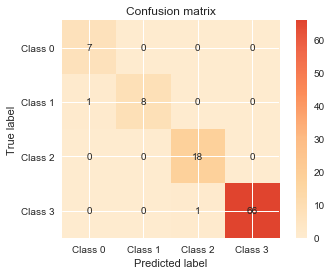

In [55]:
from sklearn_evaluation import plot
fig = plot.confusion_matrix(y_true, y_pred)

## BEST MODEL: RANDOM FOREST CLASSIFER
- It's overfit, but it's the one that performs the best across all classes


-----------------
#### ASIDE: Feature Selection: Optimize Features for Models
- If necessary: optimize features for best model

In [93]:
# labels = train_df.columns
# types = train_df.dtypes
# training_cols = list(range(0, 44))
# for i in training_cols:
#     print('training column {}: '.format(i) + str(labels[i]) + ', ' + str(types[i]))

# # Food for thought: How do I tell the difference without res (column 0) in there? LOL
# # would be nice to make dummy variables of other columns... ¯\_(ツ)_/¯

In [95]:
# y = train_df.iloc[:,-1]
# X = train_df.iloc[:,9:41]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 143)

# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [96]:
# # generate models dict
# models = {}
# models['logistic_regression'] = LogisticRegression()
# models['k_nearest_neighbors'] = KNeighborsClassifier(n_neighbors=5)
# models['gaussian_naive_bayes'] = GaussianNB()
# models['support_vect_machine'] = SVC()
# models['decision_tree_classifier'] = DecisionTreeClassifier(max_depth = 3)
# models['random_forest_classifier'] = RandomForestClassifier(max_depth = 3, n_estimators = 10)

# # models.get('logistic_regression')

##### Evaluation

In [92]:
# y_true = np.array(y_test)

# # Show which is the best recall, precision, f1, and classification

# # for exporting to pickle:
# # for name, model in models.items():
# #    model = model.fit(X_train, y_train)

# for name, model in models.items():
#     model = model.fit(X_train, y_train)
#     print('\n---------------- Model: '+ name + ' ----------------\n')
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_true, y_pred)
#     # Average parameter required for multiclass labels
#     precision = precision_score(y_true, y_pred, average='micro')
#     recall = recall_score(y_true, y_pred, average = 'micro')
#     f1 = f1_score(y_true, y_pred, average='micro')
#     print('Accuracy: ' + str(accuracy))
#     print('Precision: ' + str(precision))
#     print('Recall: ', str(recall))
#     print('F1 Score: ', str(f1))
#     print('\n' + name + ' Classification Report')
#     print('---------------------------------')
#     print(classification_report(y_true, y_pred))

In [91]:
# fig = plot.confusion_matrix(y_true, y_pred)

---------------

## Hyperparameter Optimization: 
- Goal: optimize hyperparams for best model

In [98]:
labels = train_df.columns
types = train_df.dtypes
training_cols = list(range(0, 44))
for i in training_cols:
    print('training column {}: '.format(i) + str(labels[i]) + ', ' + str(types[i]))

# Food for thought: How do I tell the difference without res (column 0) in there? LOL
# would be nice to make dummy variables of other columns... ¯\_(ツ)_/¯

training column 0: res, object
training column 1: name, object
training column 2: dam, object
training column 3: river, object
training column 4: nearby_city, object
training column 5: county, object
training column 6: basin, object
training column 7: agency, object
training column 8: elevation, int64
training column 9: lat, float64
training column 10: long, float64
training column 11: yr_complete, int64
training column 12: type, int64
training column 13: height_ft, int64
training column 14: height_m, int64
training column 15: capacity_af, int64
training column 16: capacity_1000m3, int64
training column 17: year_summer, int64
training column 18: month_10_storage, float64
training column 19: month_11_storage, float64
training column 20: month_12_storage, float64
training column 21: month_1_storage, float64
training column 22: month_2_storage, float64
training column 23: month_3_storage, float64
training column 24: month_4_storage, float64
training column 25: month_5_storage, float64
tra

In [99]:
y = train_df.iloc[:,-1]
X = train_df.iloc[:,9:41]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 143)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((235, 32), (101, 32), (235,), (101,))

In [116]:
# Random Forest Classifier
model = RandomForestClassifier(max_depth = 3, n_estimators = 3)
model = model.fit(X_train, y_train)

### Evaluation

In [117]:
y_true = np.array(y_test)

# Show which is the best recall, precision, f1, and classification

# for exporting to pickle:
# for name, model in models.items():
#    model = model.fit(X_train, y_train)


print('\n---------------- Model: RandomForestClassifier ----------------\n')
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_true, y_pred)
# Average parameter required for multiclass labels
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average = 'micro')
f1 = f1_score(y_true, y_pred, average='micro')
print('Accuracy: ' + str(accuracy))
print('Precision: ' + str(precision))
print('Recall: ', str(recall))
print('F1 Score: ', str(f1))
print('\n' + name + ' Classification Report')
print('---------------------------------')
print(classification_report(y_true, y_pred))


---------------- Model: RandomForestClassifier ----------------

Accuracy: 0.930693069307
Precision: 0.930693069307
Recall:  0.930693069307
F1 Score:  0.930693069307

random_forest_classifier Classification Report
---------------------------------
             precision    recall  f1-score   support

          0       0.88      1.00      0.93         7
          1       0.75      0.33      0.46         9
          2       0.77      0.94      0.85        18
          3       1.00      1.00      1.00        67

avg / total       0.93      0.93      0.92       101



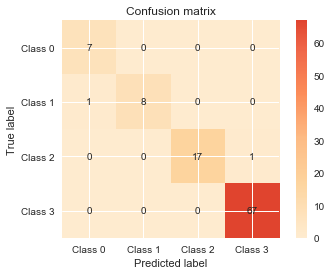

In [47]:
from sklearn_evaluation import plot
fig = plot.confusion_matrix(y_true, y_pred)

# YOU GOTTA GET A HOLDOUT SCORE

In [48]:
holdout_df.head()

,res,name,dam,river,nearby_city,county,basin,agency,elevation,lat,...,month_2_temps,month_3_temps,month_4_temps,month_5_temps,month_6_temps,month_7_temps,month_8_temps,month_9_temps,status_labels,status
336,BRV,Big Bear Lake,Bear Valley Dam,Bear Creek,SAN BERNARDINO,SAN BERNARDINO,SANTA ANA R,Big Bear Municipal Water District,6743,34.2420,...,13.903,8.712,8.813,9.804,14.463,NaN,NaN,NaN,0,0
337,BRV,Big Bear Lake,Bear Valley Dam,Bear Creek,SAN BERNARDINO,SAN BERNARDINO,SANTA ANA R,Big Bear Municipal Water District,6743,34.2420,...,0.266,0.438,0.651,0.319,0.727,NaN,NaN,NaN,0,0
338,CAS,Castaic Lake,Castaic Dam,Castaic Creek,MONROVIA,LOS ANGELES,SAN GABRIEL R,Los Angeles County,2405,34.2450,...,13.903,8.712,8.813,9.804,14.463,NaN,NaN,NaN,0,0
339,CAS,Castaic Lake,Castaic Dam,Castaic Creek,MONROVIA,LOS ANGELES,SAN GABRIEL R,Los Angeles County,2405,34.2450,...,0.266,0.438,0.651,0.319,0.727,NaN,NaN,NaN,0,0
340,CGS,Cogswell Reservoir,Cogswell Dam,"San Gabriel River, West Fork",CASTAIC,LOS ANGELES,SANTA CLARA R,"CA Dept of Water Resources, Southern Field Div",1535,34.5152,...,13.903,8.712,8.813,9.804,14.463,NaN,NaN,NaN,0,0


In [97]:
holdout_df.columns

Index(['res', 'name', 'dam', 'river', 'nearby_city', 'county', 'basin',
       'agency', 'elevation', 'lat', 'long', 'yr_complete', 'type',
       'height_ft', 'height_m', 'capacity_af', 'capacity_1000m3',
       'year_summer', 'month_10_storage', 'month_11_storage',
       'month_12_storage', 'month_1_storage', 'month_2_storage',
       'month_3_storage', 'month_4_storage', 'month_5_storage',
       'month_6_storage', 'month_7_storage', 'month_8_storage',
       'month_9_storage', 'month_10_temps', 'month_11_temps', 'month_12_temps',
       'month_1_temps', 'month_2_temps', 'month_3_temps', 'month_4_temps',
       'month_5_temps', 'month_6_temps', 'month_7_temps', 'month_8_temps',
       'month_9_temps', 'status_labels', 'status'],
      dtype='object')

# VISUALIZATION IN PLOTLY
- EXAMPLES LIBRARY: https://plot.ly/python/
- LEARNED THE HARD WAY: https://help.plot.ly/api-rate-limits/

In [49]:
import plotly
from plotly import plotly as py
import plotly.figure_factory as ff
from plotly.graph_objs import *
plotly.tools.set_config_file(world_readable=True, sharing='public')
plotly.tools.set_credentials_file(username='atomahawk', api_key='sUtD0Bml8N5I3V7yRt7Y')
plotly.__version__

'2.0.8'

In [50]:
mapbox_access_token = 'pk.eyJ1IjoiYXRvbWFoYXdrIiwiYSI6ImNqMnM0YWR3bjAwMjYyd252cTRtZzJpZWcifQ.AphbpmgHOEmotKr1Wzz0SQ'

## Plot Interactive Linegraphs
- make data look like example
- make sure data is referenced correctly
- make sure data is served up correctly

In [54]:
file_path = 'Capacitys_final.csv'
cap_df = pd.read_csv(file_path)
cap_df.head()

,res,name,dam,river,nearby_city,county,basin,agency,elevation,lat,long,yr_complete,type,height_ft,height_m,capacity_af,capacity_1000m3
0,BRV,Big Bear Lake,Bear Valley Dam,Bear Creek,SAN BERNARDINO,SAN BERNARDINO,SANTA ANA R,Big Bear Municipal Water District,6743,34.2420,-116.9780,1911,Multiple-Arch,80,24,74000,91000
1,CAS,Castaic Lake,Castaic Dam,Castaic Creek,MONROVIA,LOS ANGELES,SAN GABRIEL R,Los Angeles County,2405,34.2450,-117.9650,1973,Earth,340,100,323700,399300
2,CGS,Cogswell Reservoir,Cogswell Dam,"San Gabriel River, West Fork",CASTAIC,LOS ANGELES,SANTA CLARA R,"CA Dept of Water Resources, Southern Field Div",1535,34.5152,-118.6101,1935,Rock-fill,266,81,8969,11063
3,DMV,Diamond Valley Lake,Diamond Valley Dam,Domenigoni Valley Creek,WINCHESTER,RIVERSIDE,SANTA MARGARITA R,Metropolitan Water District,1756,33.6700,-117.0660,1999,"Earth, Rock",284,87,800000,987000
4,MHW,Lake Mathews,Mathews Dam,Cajalco Creek tributary,CORONA,RIVERSIDE,SANTA ANA AB NARROWS,Metropolitan Water District,1404,33.8330,-117.4600,1938,Earth,264,80,182000,224000


In [52]:
file_path = 'StorageAF_res_columns_final.csv'
# file_path = 'StorageAF_rotated.csv'
raw_df = pd.read_csv(file_path)
raw_df.head()

,DATE,BRV,CAS,CGS,DMV,MHW,PRR,PRU,PYM,RLC,SGB,SGC,SKN,SLW,SVO
0,6/1/00,0.80419,0.95060,0.44565,0.26514,0.79516,0.85646,0.735,0.87709,0.90958,0.62753,0.3370,0.86686,0.97986,0.02023
1,7/1/00,0.77514,0.92983,0.37853,0.28669,0.71482,0.84980,0.739,0.91191,0.84966,0.46303,0.2434,0.74871,0.96921,0.02023
2,8/1/00,0.75507,0.91235,0.31787,0.30107,0.63114,0.84565,0.741,0.89366,0.79580,0.25209,0.2424,0.76545,0.95040,0.02023
3,9/1/00,1.00000,0.88022,0.25711,0.32553,0.56074,0.84101,0.569,0.91311,0.74361,0.17000,0.2524,0.93964,0.95823,0.02023
4,10/1/00,1.00000,0.83506,0.19010,0.37187,0.50705,0.83373,0.388,0.91936,0.71244,0.14619,0.2450,0.89305,0.94899,0.02023


In [60]:
raw_df.columns

Index(['DATE', 'BRV', 'CAS', 'CGS', 'DMV', 'MHW', 'PRR', 'PRU', 'PYM', 'RLC',
       'SGB', 'SGC', 'SKN', 'SLW', 'SVO'],
      dtype='object')

In [71]:
dates = raw_df['DATE']
BRV = raw_df['BRV']
CAS = raw_df['CAS']
CGS = raw_df['CGS']
DMV = raw_df['DMV']
MHW = raw_df['MHW']
PRR = raw_df['PRR']
PRU = raw_df['PRU']
PYM = raw_df['PYM']
RLC = raw_df['RLC']
SGB = raw_df['SGB']
SGC = raw_df['SGC']
SKN = raw_df['SKN']
SLW = raw_df['SLW']
SVO = raw_df['SVO']

#fix the colors: 
trace1 = Scatter(
    x=dates, y=BRV,
    line=Line(
        color= 'rgb(255, 64, 0)',
        width=3
    ),
    name='BRV'
)

trace2 = Scatter(
    x=dates, y=CAS,
    line=Line(
        color='rgb(255, 191, 0)',
        width=3
    ),
    name='CAS'
)

trace3 = Scatter(
    x=dates, y=CGS,
    line=Line(
        color='rgb(255, 255, 0)',
        width=3
    ),
    name='CGS'
)

trace4 = Scatter(
    x=dates, y=DMV,
    line=Line(
        color='rgb(64, 255, 0)',
        width=3
    ),
    name='DMV'
)

trace5 = Scatter(
    x=dates, y=MHW,
    line=Line(
        color='rgb(0, 255, 191)',
        width=3
    ),
    name='MHW'
)

trace6 = Scatter(
    x=dates, y=PRR,
    line=Line(
        color='rgb(0, 191, 255)',
        width=3
    ),
    name='PRR'
)

trace7 = Scatter(
    x=dates, y=PRU,
    line=Line(
        color='rgb(0, 64, 255)',
        width=3
    ),
    name='PRU'
)

trace8 = Scatter(
    x=dates, y=PYM,
    line=Line(
        color='#000000',
        width=3
    ),
    name='PYM'
)

trace9 = Scatter(
    x=dates, y=RLC,
    line=Line(
        color='rgb(128, 0, 255)',
        width=3
    ),
    name='RLC'
)

trace10 = Scatter(
    x=dates, y=SGB,
    line=Line(
        color='rgb(255, 0, 191)',
        width=3
    ),
    name='SGB'
)

trace11 = Scatter(
    x=dates, y=SGC,
    line=Line(
        color='rgb(204, 0, 10',
        width=3
    ),
    name='SGC'
)

trace12 = Scatter(
    x=dates, y=SKN,
    line=Line(
        color='rgb(204, 102, 0)',
        width=3
    ),
    name='SKN'
)

trace13 = Scatter(
    x=dates, y=SLW,
    line=Line(
        color='rgb(117, 102, 87)',
        width=3
    ),
    name='SLW'
)

trace14 = Scatter(
    x=dates, y=SVO,
    line=Line(
        color='rgb(0, 0, 0)',
        width=3
    ),
    name='SVO'
)

data = Data([trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8, trace9, trace10, trace11, trace12, trace13, trace14])
layout = Layout(
    title='Storage for Major Reservoirs around Los Angeles County',
    updatemenus=list([
        dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons=list([
                # fix the booleans
                dict(
                    args=['visible', [True, True, True, True, True, True, True, True, True, True, True, True, True, True]],
                    label='All',
                    method='restyle'
                ),
                dict(
                    args=['visible', [True, False, False, False, False, False, False, False, False, False, False, False, False, False]],
                    label='BRV',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False, False, False, False, False, False, False, False, False, False, False, False]],
                    label='CAS',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True, False, False, False, False, False, False, False, False, False, False, False]],
                    label='CGS',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, True, False, False, False, False, False, False, False, False, False, False]],
                    label='DMV',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, True, False, False, False, False, False, False, False, False, False]],
                    label='MHW',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, True, False, False, False, False, False, False, False, False]],
                    label='PRR',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, True, False, False, False, False, False, False, False]],
                    label='PRU',
                    method='restyle'
                ),
                
                dict(
                    args=['visible', [False, False, False, False, False, False, False, True, False, False, False, False, False, False]],
                    label='PYM',
                    method='restyle'
                ),
                
                dict( 
                    args=['visible', [False, False, False, False, False, False, False, False, True, False, False, False, False, False]], 
                    label='RLC', 
                    method='restyle'
                ),
                
                dict(
                    args=['visible', [False, False, False, False, False, False, False, False, False, True, False, False, False, False]],
                    label='SGB',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, False, False, False, False, True, False, False, False]],
                    label='SGC',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, False, False, False, False, False, True, False, False]],
                    label='SKN',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, False, False, False, False, False, False, True, False]],
                    label='SLW',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, False, False, False, False, False, False, False, True]],
                    label='SVO',
                    method='restyle'
                )
            ]),
        )
    ]),
)
fig = Figure(data=data, layout=layout)
py.iplot(fig, filename = 'LA Reservoir Storage over Time')

## Plot Interactive Mapbox with Dropdown Menus
- make sure each year gets its own map
  - maybe timeseries: https://plot.ly/python/time-series/
  - scatterbox documentation: https://plot.ly/python/reference/#scattermapbox
  
  
- make sure data is referenced correctly
- make sure data is served up correctly
- serve it up as a dashboard: https://plot.ly/python/create-online-dashboard/
- embed in html: https://plot.ly/python/embedding-plotly-graphs-in-HTML/

In [67]:
json_data = pd.read_json('https://raw.githubusercontent.com/ottlngr/2016-15/ottlngr/ottlngr/sites.json')

In [70]:
json_data['locations'][7]

[{'latitude': 41.060828,
  'longitude': -80.637267,
  'name': '',
  'postal_code': '44512',
  'street_address': '3991 Simon Road'}]

In [68]:
json_data['site'][7]

{'city': 'Youngstown',
 'name': 'Ajax Magnethermic Corp.',
 'rating': 2,
 'slug': '8-ajax-magnethermic-corp',
 'state': 'OH',
 'state_ap': 'Ohio'}

In [78]:
df3 = df2
df3['full_name'] = df3['name'] +' ('+ df3['res'] +')'
# df4 = df3[df3['year_summer'] == 2001]
# df4.shape

(28, 45)

In [89]:
site_lat = []
site_lon = []
res_name = []
colors = []
year_list = list(df['year_summer'].unique())

for year in year_list:
    tmp_df = df[df['year_summer'] == year]
    for index in range(len(tmp_df)):
        site_lat.append(tmp_df['lat'][index])
        site_lon.append(tmp_df['long'][index])
        res_name.append(tmp_df['full_name'][index])

        # add colors to list depending on 'status' value
        if tmp_df['status'][index] == 3:
            colors.append('rgb(0, 204, 0)')
        elif tmp_df['status'][index] == 2:
            colors.append('rgb(255, 255, 82)')
        elif tmp_df['status'][index] == 1:
            colors.append('rgb(255, 168, 82)')
        else:
            colors.append('rgb(255, 80, 80)')

    data = Data([
        Scattermapbox(
            lat=site_lat,
            lon=site_lon,
            mode='markers',
            marker=Marker(
                size=17,
                color=colors,
                opacity=0.7
            ),
            text=res_name,
            hoverinfo='text',
            showlegend=False
        ),
        Scattermapbox(
            lat=site_lat,
            lon=site_lon,
            mode='markers',
            marker=Marker(
                size=8,
                color='rgb(168, 168, 168)',
                opacity=0.01
            ),
            hoverinfo='skip',
            showlegend=False
        )
    ])

    layout = Layout(
        title='Reservoir Storage Capacities in {}'.format(tmp_df['year_summer'][1]),
        autosize=True,
        hovermode='closest',
        mapbox=dict(
            accesstoken=mapbox_access_token,
            bearing=0,
            # centered on SGB
            center=dict(
                lat=34.207,
                lon=-117.858
            ),
            pitch=0,
            zoom=7,
            style='light'
        )
    )

    fig = dict(data=data, layout=layout)
    py.iplot(fig, filename='Reservoir Storage Capacities in ' + str(year))

In [ ]:
site_lat = []
site_lon = []
res_name = []
colors = []
for index in range(len(df4)):
    site_lat.append(df4['lat'][index])
    site_lon.append(df4['long'][index])
    res_name.append(df4['full_name'][index])

    # add colors to list depending on 'status' value
    if df4['status'][index] == 3:
        colors.append('rgb(0, 204, 0)')
    elif df4['status'][index] == 2:
        colors.append('rgb(255, 255, 82)')
    elif df4['status'][index] == 1:
        colors.append('rgb(255, 168, 82)')
    else:
        colors.append('rgb(255, 80, 80)')

data = Data([
    Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=Marker(
            size=17,
            color=colors,
            opacity=0.7
        ),
        text=res_name,
        hoverinfo='text',
        showlegend=False
    ),
    Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=Marker(
            size=8,
            color='rgb(168, 168, 168)',
            opacity=0.01
        ),
        hoverinfo='skip',
        showlegend=False
    )
])

layout = Layout(
    title='Reservoir Storage Capacities in {}'.format(df4['year_summer'][1]),
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        # centered on SGB
        center=dict(
            lat=34.207,
            lon=-117.858
        ),
        pitch=0,
        zoom=7,
        style='light'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Reservoir Storage Capacities in 2001')

In [72]:
json_data.head(30)

,locations,site
0,"[{'latitude': 43.02938, 'longitude': -83.65525...","{'city': 'Flint', 'name': 'AC Spark Plug, Dort..."
1,[],"{'city': 'Albuquerque', 'name': 'ACF Industrie..."
2,[],"{'city': 'Buffalo', 'name': 'ACF Industries, I..."
3,"[{'latitude': 35.8888273, 'longitude': -106.30...","{'city': 'Los Alamos', 'name': 'Acid/Pueblo Ca..."
4,"[{'latitude': 39.952953, 'longitude': -75.5927...","{'city': 'West Chester', 'name': 'Aeroprojects..."
5,"[{'latitude': 40.705709, 'longitude': -74.0110...","{'city': 'New York', 'name': 'African Metals',..."
6,"[{'latitude': 39.2351293, 'longitude': -84.446...","{'city': 'Evendale/Lockland', 'name': 'Air For..."
7,"[{'latitude': 41.060828, 'longitude': -80.6372...","{'city': 'Youngstown', 'name': 'Ajax Magnether..."
8,"[{'latitude': None, 'longitude': None, 'postal...","{'city': 'Talladega County', 'name': 'Alabama ..."
9,"[{'latitude': 39.5034873, 'longitude': -84.743...","{'city': 'Oxford', 'name': 'Alba Craft Shop', ..."


In [ ]:
site_lat = []
site_lon = []
locations_name = []
colors = []

for index in range(len(json_data)):
    if json_data['locations'][index] != []:
        site_lat.append(json_data['locations'][index][0]['latitude'])
        site_lon.append(json_data['locations'][index][0]['longitude'])
        locations_name.append(json_data['site'][index]['name'])
        # add colors to list depending on 'rating' value
        if json_data['site'][index]['rating'] == 0:
            colors.append('rgb(247, 200, 108)')
        elif json_data['site'][index]['rating'] == 1:
            colors.append('rgb(79, 161, 69)')
        elif json_data['site'][index]['rating'] == 2:
            colors.append('rgb(255, 0, 0)')
        else:
            colors.append('rgb(0, 0, 0)')

data = Data([
    Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=Marker(
            size=17,
            color=colors,
            opacity=0.7
        ),
        text=locations_name,
        hoverinfo='text',
        showlegend=False
    ),
    Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=Marker(
            size=8,
            color='rgb(242, 177, 172)',
            opacity=0.7
        ),
        hoverinfo='skip',
        showlegend=False
    )
])
        
layout = Layout(
    title='All Nuclear Waste Sites and their Current Status',
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=38,
            lon=-94
        ),
        pitch=0,
        zoom=3,
        style='light'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='All Nuclear Waste Sites and their Current Status')